<a href="https://colab.research.google.com/github/adobamenphoebe/coffee-shop-analytics/blob/main/notebooks/coffee_shop_eda_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coffee Shop EDA and Seasonal Drink Recommender

This notebook loads sales, survey (GACTT), and Yelp sentiment data, performs basic EDA, and builds a simple rule-based recommender.

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

BASE = "https://raw.githubusercontent.com/adobamenphoebe/coffee-shop-analytics/main/data/"

sales = pd.read_csv(BASE + "merged_sales_product.csv", parse_dates=["transaction_date"])
outlets = pd.read_csv(BASE + "sales_outlet_clean.csv")
products = pd.read_csv(BASE + "product_clean.csv")
customers = pd.read_csv(BASE + "customer_clean.csv")
survey = pd.read_csv(BASE + "GACTT_RESULTS_ANONYMIZED_v2.csv")
yelp_sent = pd.read_csv(BASE + "sentiments_by_shop.csv")


OUTPUT_PATH = "/content/outputs/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

sales.head()


,transaction_id,transaction_date,transaction_time,sales_outlet_id,staff_id,customer_id,instore_yn,order,line_item_id,product_id,quantity,line_item_amount,unit_price,promo_item_yn,product,product_category
0,7,2019-04-01,12:04:43,3,12,558,N,1,1,52,1,2.50,2.50,N,Traditional Blend Chai Rg,Tea
1,11,2019-04-01,15:54:39,3,17,781,N,1,1,27,2,7.00,3.50,N,Brazilian Lg,Coffee
2,19,2019-04-01,14:34:59,3,17,788,Y,1,1,46,2,5.00,2.50,N,Serenity Green Tea Rg,Tea
3,32,2019-04-01,16:06:04,3,12,683,N,1,1,23,2,5.00,2.50,N,Our Old Time Diner Blend Rg,Coffee
4,33,2019-04-01,19:18:37,3,17,99,Y,1,1,34,1,2.45,2.45,N,Jamaican Coffee River Sm,Coffee


In [4]:
# feature engineering
sales["date"] = sales["transaction_date"].dt.date
sales["dayofweek"] = sales["transaction_date"].dt.day_name()
sales["month"] = sales["transaction_date"].dt.month

daily_rev = (sales.groupby("date")["line_item_amount"]
             .sum()
             .reset_index()
             .rename(columns={"line_item_amount": "daily_revenue"}))
daily_rev.head()

,date,daily_revenue
0,2019-04-01,7462.00
1,2019-04-02,7269.10
2,2019-04-03,7461.25
3,2019-04-04,7086.45
4,2019-04-05,7236.25


In [5]:
# top products
top_products = (sales.groupby("product")["line_item_amount"]
                .sum()
                .reset_index()
                .sort_values("line_item_amount", ascending=False))
top_products.head(10)

,product,line_item_amount
75,Sustainably Grown Organic Lg,7106.00
20,Dark chocolate Lg,6957.00
48,Latte Rg,6328.25
6,Cappuccino Lg,6056.25
53,Morning Sunrise Chai Lg,5900.00
47,Latte,5741.25
76,Sustainably Grown Organic Rg,5467.50
43,Jamaican Coffee River Lg,5467.50
5,Cappuccino,5456.25
31,Ethiopia Lg,5064.50


In [6]:
# survey parsing based on provided columns

fav_col_1 = "What is your favorite coffee drink?"
fav_col_2 = "Please specify what your favorite coffee drink is"

survey_favs = []
if fav_col_1 in survey.columns:
    survey_favs.append(survey[fav_col_1].dropna().str.strip().str.title())
if fav_col_2 in survey.columns:
    survey_favs.append(survey[fav_col_2].dropna().str.strip().str.title())

if survey_favs:
    survey_favs = pd.concat(survey_favs)
    fav_counts = (survey_favs.value_counts()
                  .reset_index()
                  .rename(columns={"index": "drink_name", 0: "mentions"}))
else:
    fav_counts = pd.DataFrame(columns=["drink_name", "mentions"])

fav_counts.head(10)

,drink_name,count
0,Pourover,1084
1,Latte,680
2,Regular Drip Coffee,442
3,Cappuccino,341
4,Espresso,330
5,Cortado,314
6,Americano,250
7,Iced Coffee,156
8,Mocha,118
9,Other,114


In [8]:
# normalize drink names
def normalize_drink_name(s):
    if pd.isna(s):
        return None
    s = s.lower().strip()
    s = s.replace("iced ", "")
    s = s.replace("ice ", "")
    s = s.replace("latte ", "latte")
    return s

# Prepare recommendation dataframe
reco = top_products.copy()
reco.rename(columns={"line_item_amount": "sales_revenue"}, inplace=True)
reco["product_norm"] = reco["product"].apply(normalize_drink_name)

# Prepare survey frequency dataframe
fav_counts["drink_norm"] = fav_counts["drink_name"].apply(normalize_drink_name)

reco = reco.merge(
    fav_counts[["drink_norm", "count"]],
    left_on="product_norm",
    right_on="drink_norm",
    how="left"
)


reco.rename(columns={"count": "mentions"}, inplace=True)


In [9]:
def minmax(s):
    if s.max() == s.min():
        return pd.Series(1.0, index=s.index)
    return (s - s.min()) / (s.max() - s.min())

# Scores
reco["sales_score"] = minmax(reco["sales_revenue"])

reco["survey_popularity_score"] = reco["mentions"].fillna(0)
if reco["survey_popularity_score"].max() > 0:
    reco["survey_popularity_score"] = (
        reco["survey_popularity_score"] /
        reco["survey_popularity_score"].max()
    )

# Yelp sentiment fallback
if "yelp_sent" in globals() and not yelp_sent.empty and "avg_sentiment" in yelp_sent.columns:
    sentiment_default = yelp_sent["avg_sentiment"].mean()
else:
    sentiment_default = 0.1

reco["sentiment_score"] = sentiment_default

# Final weighted score
reco["final_score"] = (
    0.55 * reco["sales_score"] +
    0.30 * reco["survey_popularity_score"] +
    0.10 * reco["sentiment_score"] +
    0.05 * 1
)

reco_sorted = reco.sort_values("final_score", ascending=False)
reco_sorted.head(15)


,product,sales_revenue,product_norm,drink_norm,mentions,sales_score,survey_popularity_score,sentiment_score,final_score
5,Latte,5741.25,latte,latte,680.0,0.801508,1.000000,0.1,0.800830
9,Cappuccino,5456.25,cappuccino,cappuccino,341.0,0.760057,0.501471,0.1,0.628473
0,Sustainably Grown Organic Lg,7106.00,sustainably grown organic lg,NaN,NaN,1.000000,0.000000,0.1,0.610000
1,Dark chocolate Lg,6957.00,dark chocolate lg,NaN,NaN,0.978329,0.000000,0.1,0.598081
2,Latte Rg,6328.25,latterg,NaN,NaN,0.886883,0.000000,0.1,0.547785
3,Cappuccino Lg,6056.25,cappuccino lg,NaN,NaN,0.847322,0.000000,0.1,0.526027
4,Morning Sunrise Chai Lg,5900.00,morning sunrise chai lg,NaN,NaN,0.824597,0.000000,0.1,0.513528
6,Latte,5741.25,latte,latte,1.0,0.801508,0.001471,0.1,0.501271
7,Sustainably Grown Organic Rg,5467.50,sustainably grown organic rg,NaN,NaN,0.761694,0.000000,0.1,0.478931
8,Jamaican Coffee River Lg,5467.50,jamaican coffee river lg,NaN,NaN,0.761694,0.000000,0.1,0.478931


In [10]:
# export
daily_rev.to_csv(OUTPUT_PATH + "daily_revenue.csv", index=False)
top_products.to_csv(OUTPUT_PATH + "top_products.csv", index=False)
reco_sorted.head(50).to_csv(OUTPUT_PATH + "drink_recommendations.csv", index=False)

"exports written"


'exports written'

## Visualizations

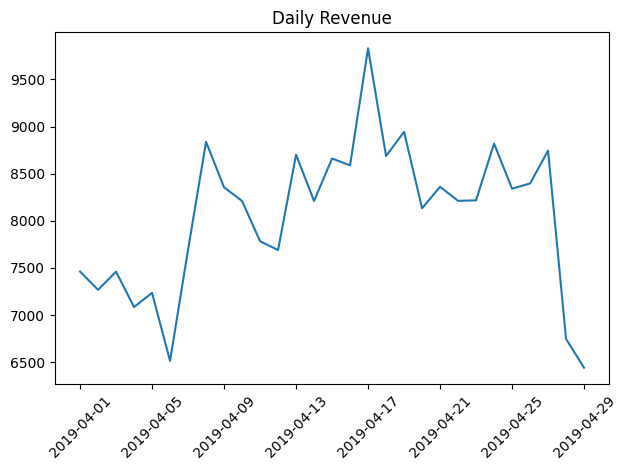

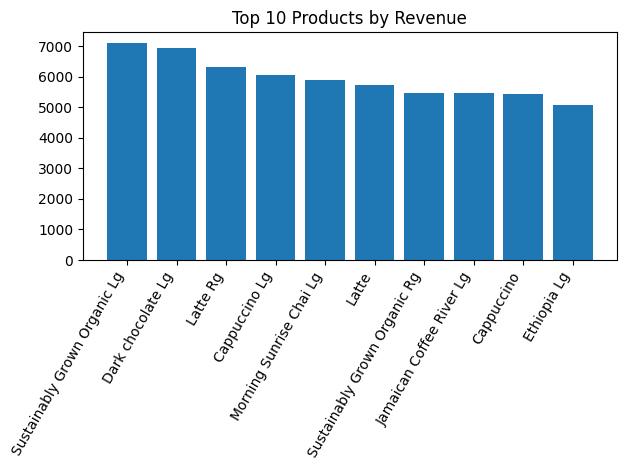

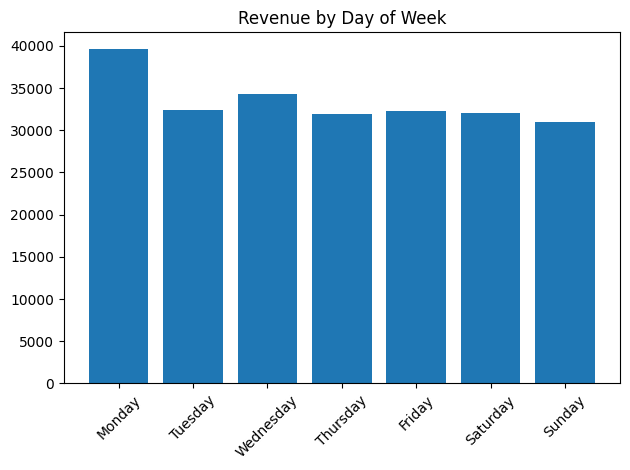

In [11]:
import matplotlib.pyplot as plt

# daily revenue plot
plt.figure()
plt.plot(daily_rev["date"], daily_rev["daily_revenue"])
plt.title("Daily Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# top 10 products bar
top10 = top_products.head(10)
plt.figure()
plt.bar(top10["product"], top10["line_item_amount"])
plt.title("Top 10 Products by Revenue")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# revenue by day of week
dow_rev = (sales.groupby("dayofweek")["line_item_amount"]
           .sum()
           .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
           .reset_index())
plt.figure()
plt.bar(dow_rev["dayofweek"], dow_rev["line_item_amount"])
plt.title("Revenue by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()